# Cartesian Model
## Nightingale Corona

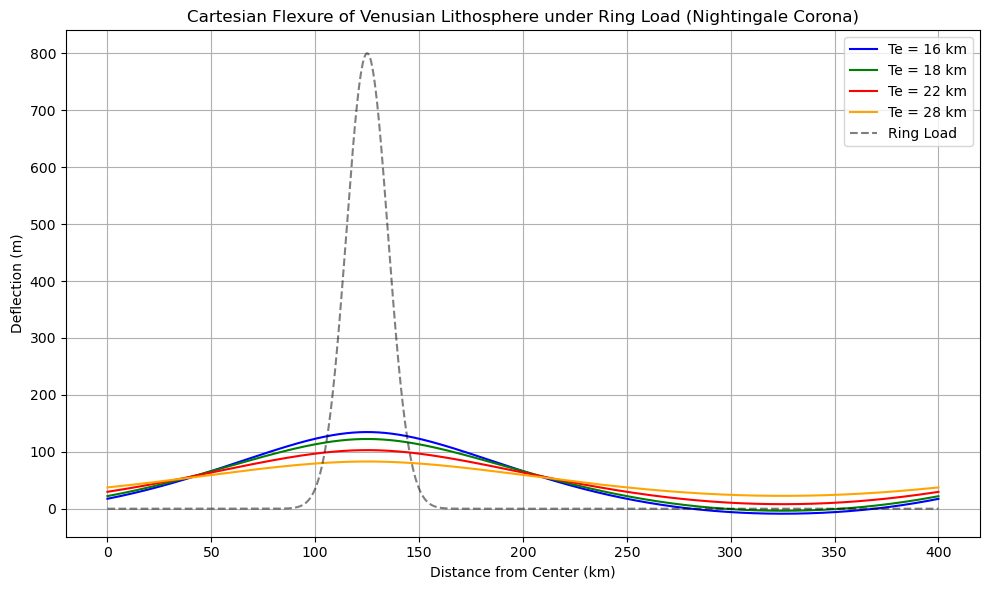

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
rho_c = 2900       # Crust density (kg/m^3)
rho_m = 3300       # Mantle density (kg/m^3)
g = 8.87           # Venus gravity (m/s^2)
E = 7e10           # Young's modulus (Pa)
nu = 0.25          # Poisson's ratio

# Flexural rigidity from elastic thickness
def D_from_Te(Te_km):
    Te_m = Te_km * 1e3
    return (E * Te_m**3) / (12 * (1 - nu**2))

# Define spatial domain
x = np.linspace(0, 400e3, 2000)
dx = x[1] - x[0]

# Define a "ring" as two Gaussian loads
def ring_load(x, x0_km=125, width_km=10, height_m=800):
    r0 = r0_km * 1e3
    sigma = width_km * 1e3
    return height_m * (np.exp(-((x - x0)**2) / (2 * sigma**2)) + 
                       np.exp(-((x + x0)**2) / (2 * sigma**2)))

# Load profile
load = ring_load(x)

# FFT wave numbers
k = 2 * np.pi * np.fft.fftfreq(x.size, d=dx)
k[0] = 1e-10  # avoid division by zero

load_fft = np.fft.fft(load)

# Try different elastic thicknesses
Te_values = [16, 18, 22, 28] # in km
colors = ['blue', 'green', 'red', 'orange']

# Plot
plt.figure(figsize=(10, 6))

for Te, color in zip(Te_values, colors):
    D = D_from_Te(Te)
    denom = 1 + (D * k**4) / ((rho_m - rho_c) * g)
    w_fft = load_fft / denom
    w = np.real(np.fft.ifft(w_fft))
    plt.plot(x / 1e3, w, label=f'Te = {Te} km', color=color)

plt.plot(x / 1e3, load, 'k--', label='Ring Load', alpha=0.5)
plt.title("Cartesian Flexure of Venusian Lithosphere under Ring Load (Nightingale Corona)")
plt.xlabel("Distance from Center (km)")
plt.ylabel("Deflection (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Axisymmetric Model
## Nightingale Corona is best modelled with a ring load

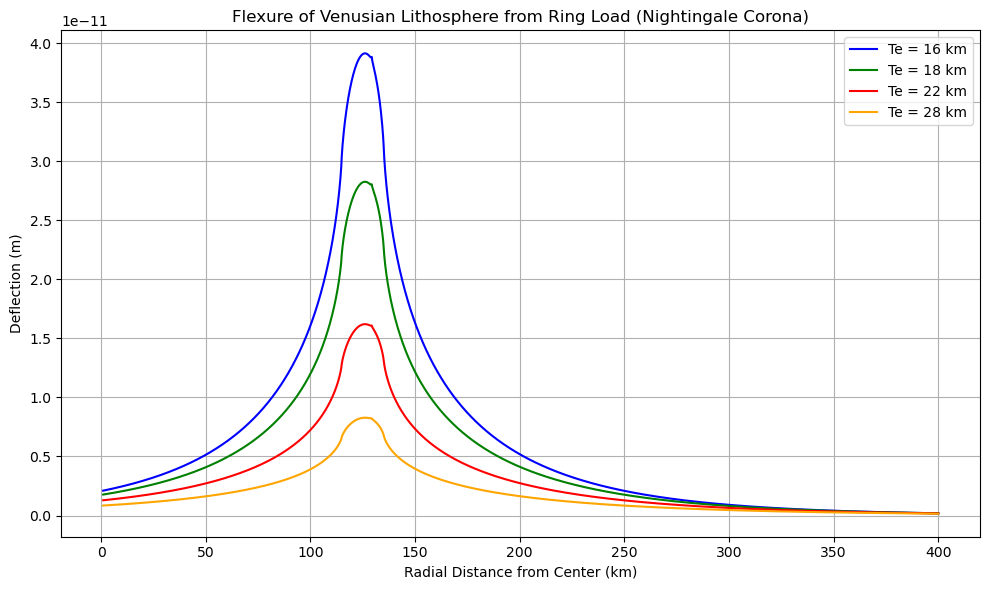

[2.5486222222222223e+22, 3.6288e+22, 6.625422222222223e+22, 1.3659022222222224e+23]


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv as K_v  # Modified Bessel function of the second kind

# Constants
rho_c = 2900       # Crust density (kg/m^3)
rho_m = 3300       # Mantle density (kg/m^3)
g = 8.87           # Gravity on Venus (m/s^2)
E = 7e10           # Young's modulus (Pa)
nu = 0.25          # Poisson's ratio

# Flexural rigidity from elastic thickness
def D_from_Te(Te_km):
    Te_m = Te_km * 1e3
    return (E * Te_m**3) / (12 * (1 - nu**2))

# Flexural parameter
def alpha(D):
    return (4 * D / ((rho_m - rho_c) * g))**0.25

# Deflection from a ring load centered at radius r0
def ring_deflection(r, D, Q_ring, r0, dr=5e3):
    """
    r: radial positions to compute deflection at (array)
    D: flexural rigidity
    Q_ring: total load applied in the ring (Nm)
    r0: center radius of the ring (m)
    dr: half-width of the ring (m)
    """
    a = alpha(D)
    # Normalize Q_ring over ring circumference
    ring_circumference = 2 * np.pi * r0
    q = Q_ring / (2 * np.pi * r0 * dr)  # Load per unit length per unit width

    # Numerical integration over the ring
    r_prime = np.linspace(r0 - dr, r0 + dr, 100)
    w = np.zeros_like(r)
    for rp in r_prime:
        dQ = q * 2 * np.pi * rp * (r_prime[1] - r_prime[0])
        w += dQ / (2 * np.pi * D) * K_v(0, np.abs(r - rp) / a)
    return w

# Radial domain
r = np.linspace(1e3, 400e3, 2000)  # from 1 km to 400 km

# Load parameters
Q_ring = 1e12       # Nm, total load applied in the ring
r0 = 125e3          # center of ring at 125 km radius (~250 km wide corona)
dr = 10e3           # ring width ±10 km

# Plate thicknesses to try
Te_values = [16, 18, 22, 28]
colors = ['blue', 'green', 'red', 'orange']
D_vals = []
# Plot
plt.figure(figsize=(10, 6))

for Te, color in zip(Te_values, colors):
    D = D_from_Te(Te)
    D_vals.append(D)
    w = ring_deflection(r, D, Q_ring, r0, dr=dr)
    plt.plot(r / 1e3, w, label=f'Te = {Te} km', color=color)

plt.title("Flexure of Venusian Lithosphere from Ring Load (Nightingale Corona)")
plt.xlabel("Radial Distance from Center (km)")
plt.ylabel("Deflection (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(D_vals)

# Possible Chasm Stuff

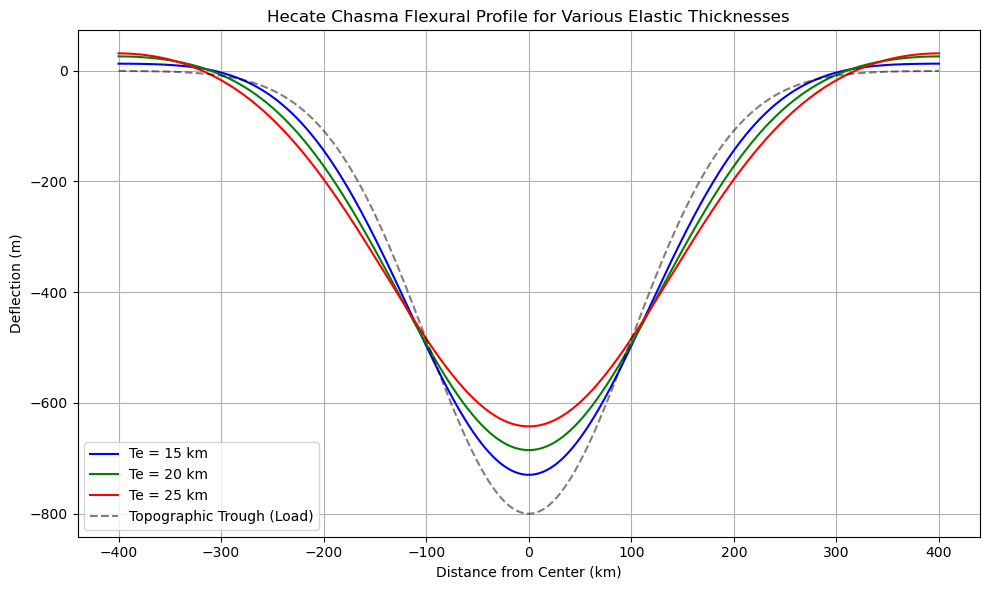

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Physical constants
rho_c = 2900      # Crust density (kg/m^3)
rho_m = 3300      # Mantle density (kg/m^3)
g = 8.87          # Venus gravity (m/s^2)
E = 7e10          # Young's modulus (Pa)
nu = 0.25         # Poisson's ratio

# Convert elastic thickness (km) to flexural rigidity D (Nm)
def Te_to_D(Te_km):
    Te_m = Te_km * 1e3
    return (E * Te_m**3) / (12 * (1 - nu**2))

# Spatial domain
x = np.linspace(-400e3, 400e3, 2000)  # ±400 km
dx = x[1] - x[0]

# Hecate Chasma trough: modeled as a Gaussian depression
load_width = 100e3     # ~200 km wide
load_depth = -800      # ~0.8 km deep depression
load = load_depth * np.exp(-x**2 / (2 * load_width**2))

# FFT setup
k = 2 * np.pi * np.fft.fftfreq(x.size, d=dx)
load_fft = np.fft.fft(load)

# Range of elastic thicknesses from paper
Te_values = [15, 20, 25]  # in km
colors = ['blue', 'green', 'red']

# Plot modeled flexure
plt.figure(figsize=(10, 6))

for Te, color in zip(Te_values, colors):
    D = Te_to_D(Te)
    denom = 1 + (D * k**4) / ((rho_m - rho_c) * g)
    w_fft = load_fft / denom
    w = np.real(np.fft.ifft(w_fft))
    plt.plot(x / 1e3, w, label=f'Te = {Te} km', color=color)

plt.plot(x / 1e3, load, 'k--', label='Topographic Trough (Load)', alpha=0.5)
plt.title("Hecate Chasma Flexural Profile for Various Elastic Thicknesses")
plt.xlabel("Distance from Center (km)")
plt.ylabel("Deflection (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


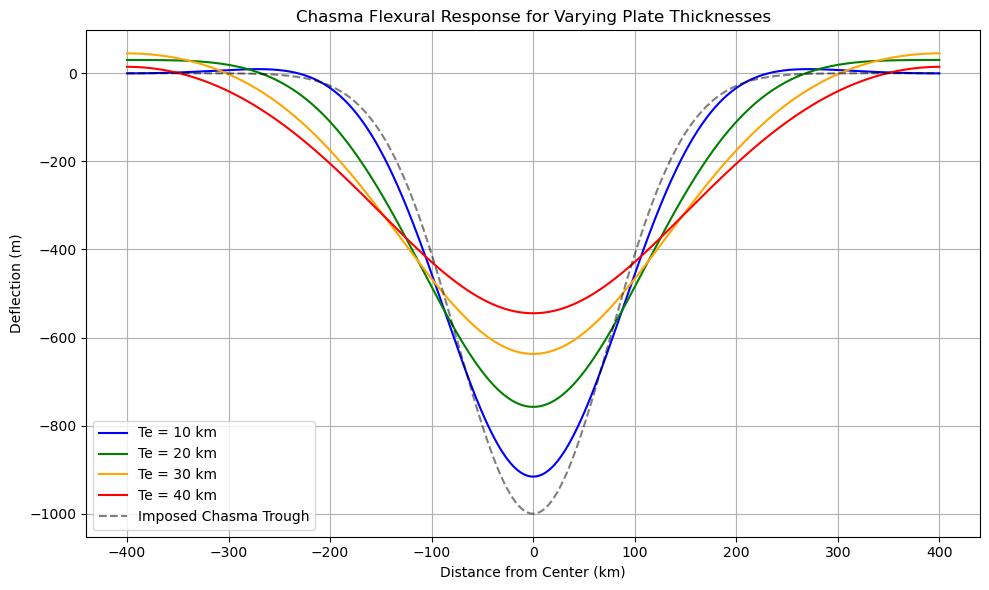

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
rho_c = 2900      # Crust density (kg/m^3)
rho_m = 3300      # Mantle density (kg/m^3)
g = 8.87          # Venus surface gravity (m/s^2)
E = 7e10          # Young's modulus (Pa)
nu = 0.25         # Poisson's ratio

# Convert Te (km) to flexural rigidity D (Nm)
def Te_to_D(Te_km):
    Te_m = Te_km * 1e3
    return (E * Te_m**3) / (12 * (1 - nu**2))

# Domain
x = np.linspace(-400e3, 400e3, 2000)  # ±400 km
dx = x[1] - x[0]

# Gaussian "trough" load to simulate rift valley
load_width = 75e3     # Width of chasma ~150 km
load_amplitude = -1000  # Negative for depression
load = load_amplitude * np.exp(-x**2 / (2 * load_width**2))

# Fourier transform setup
k = 2 * np.pi * np.fft.fftfreq(x.size, d=dx)
load_fft = np.fft.fft(load)

# Elastic thicknesses to compare
Te_values = [10, 20, 30, 40]  # in km
colors = ['blue', 'green', 'orange', 'red']

# Plotting
plt.figure(figsize=(10, 6))

for Te, color in zip(Te_values, colors):
    D = Te_to_D(Te)
    denom = 1 + (D * k**4) / ((rho_m - rho_c) * g)
    w_fft = load_fft / denom
    w = np.real(np.fft.ifft(w_fft))
    plt.plot(x / 1e3, w, label=f'Te = {Te} km', color=color)

plt.plot(x / 1e3, load, 'k--', label='Imposed Chasma Trough', alpha=0.5)
plt.title("Chasma Flexural Response for Varying Plate Thicknesses")
plt.xlabel("Distance from Center (km)")
plt.ylabel("Deflection (m)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
